In [1]:
# Este entorno de Python 3 es similar a Jupyter Notebook
# Viene con varias librerías instaladas. Para más információn podés consultar 
# la imagen de docker que utiliza (https://github.com/kaggle/docker-python)

import numpy as np 
import pandas as pd
import tensorflow.keras
import matplotlib.pyplot as plt
%matplotlib inline

# Los archivos del zip "aap2020unlp.zip" están disponibles automáticamente en la 
# carpeta "/kaggle/input/aap2020unlp"
# (o "../input/aap2020unlp")
# Por ejemplo, el siguiente código imprime todos los archivos disponibles:
import os
for dirname, _, filenames in os.walk('/tf/data/aa2020/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Cualquier resultado que guarden en el directorio actual queda como un "output" en el workspace

/tf/data/aa2020/data/v1/derived.csv
/tf/data/aa2020/data/v1/aa2019unlp.zip
/tf/data/aa2020/data/v1/val/pneumonia/0176.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0255.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0124.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0278.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0340.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0174.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0056.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0339.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0305.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0059.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0248.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0090.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0341.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0196.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0103.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0120.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0276.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0277.jpg
/tf/data/aa2020/data/v1/val/pneumonia/0197.jpg
/tf/data/aa2020/data/v1/val/pneu

/tf/data/aa2020/data/v1/dataset/pneumonia/4998.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3340.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3779.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1116.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5157.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/0709.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/2352.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/0291.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5583.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/2747.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1002.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/0911.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1770.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5882.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/4545.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/4326.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5303.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5689.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3488.jpg
/tf/data/aa2020/data/v1/dataset

/tf/data/aa2020/data/v1/dataset/pneumonia/3044.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/4743.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1683.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3626.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/0286.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3005.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5770.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/2670.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3104.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5363.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1581.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3609.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/4166.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/4959.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3113.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/3700.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/1955.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/5447.jpg
/tf/data/aa2020/data/v1/dataset/pneumonia/0647.jpg
/tf/data/aa2020/data/v1/dataset

/tf/data/aa2020/data/v1/dataset/normal/1428.jpg
/tf/data/aa2020/data/v1/dataset/normal/2048.jpg
/tf/data/aa2020/data/v1/dataset/normal/0641.jpg
/tf/data/aa2020/data/v1/dataset/normal/0152.jpg
/tf/data/aa2020/data/v1/dataset/normal/1145.jpg
/tf/data/aa2020/data/v1/dataset/normal/1607.jpg
/tf/data/aa2020/data/v1/dataset/normal/0472.jpg
/tf/data/aa2020/data/v1/dataset/normal/0524.jpg
/tf/data/aa2020/data/v1/dataset/normal/2187.jpg
/tf/data/aa2020/data/v1/dataset/normal/0044.jpg
/tf/data/aa2020/data/v1/dataset/normal/1983.jpg
/tf/data/aa2020/data/v1/dataset/normal/2516.jpg
/tf/data/aa2020/data/v1/dataset/normal/1018.jpg
/tf/data/aa2020/data/v1/dataset/normal/0534.jpg
/tf/data/aa2020/data/v1/dataset/normal/0966.jpg
/tf/data/aa2020/data/v1/dataset/normal/0220.jpg
/tf/data/aa2020/data/v1/dataset/normal/0929.jpg
/tf/data/aa2020/data/v1/dataset/normal/1103.jpg
/tf/data/aa2020/data/v1/dataset/normal/0562.jpg
/tf/data/aa2020/data/v1/dataset/normal/2587.jpg
/tf/data/aa2020/data/v1/dataset/normal/2

/tf/data/aa2020/data/v1/dataset/normal/2605.jpg
/tf/data/aa2020/data/v1/dataset/normal/2898.jpg
/tf/data/aa2020/data/v1/dataset/normal/0143.jpg
/tf/data/aa2020/data/v1/dataset/normal/2299.jpg
/tf/data/aa2020/data/v1/dataset/normal/2097.jpg
/tf/data/aa2020/data/v1/dataset/normal/2770.jpg
/tf/data/aa2020/data/v1/dataset/normal/1147.jpg
/tf/data/aa2020/data/v1/dataset/normal/1960.jpg
/tf/data/aa2020/data/v1/dataset/normal/0104.jpg
/tf/data/aa2020/data/v1/dataset/normal/0411.jpg
/tf/data/aa2020/data/v1/dataset/normal/1193.jpg
/tf/data/aa2020/data/v1/dataset/normal/0477.jpg
/tf/data/aa2020/data/v1/dataset/normal/1843.jpg
/tf/data/aa2020/data/v1/dataset/normal/1665.jpg
/tf/data/aa2020/data/v1/dataset/normal/2175.jpg
/tf/data/aa2020/data/v1/dataset/normal/0742.jpg
/tf/data/aa2020/data/v1/dataset/normal/0494.jpg
/tf/data/aa2020/data/v1/dataset/normal/1647.jpg
/tf/data/aa2020/data/v1/dataset/normal/2054.jpg
/tf/data/aa2020/data/v1/dataset/normal/1589.jpg
/tf/data/aa2020/data/v1/dataset/normal/2

/tf/data/aa2020/data/v1/train/pneumonia/3750.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2073.jpg
/tf/data/aa2020/data/v1/train/pneumonia/4257.jpg
/tf/data/aa2020/data/v1/train/pneumonia/4395.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1340.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0508.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1221.jpg
/tf/data/aa2020/data/v1/train/pneumonia/3054.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2826.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0162.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2960.jpg
/tf/data/aa2020/data/v1/train/pneumonia/3699.jpg
/tf/data/aa2020/data/v1/train/pneumonia/3595.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0372.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1232.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1106.jpg
/tf/data/aa2020/data/v1/train/pneumonia/4379.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2940.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2276.jpg
/tf/data/aa2020/data/v1/train/pneumonia/4333.jpg
/tf/data/aa2020/data

/tf/data/aa2020/data/v1/train/pneumonia/4066.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2659.jpg
/tf/data/aa2020/data/v1/train/pneumonia/3709.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1537.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1538.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0767.jpg
/tf/data/aa2020/data/v1/train/pneumonia/4086.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2370.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1536.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0192.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0634.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0258.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0071.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0458.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2284.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0275.jpg
/tf/data/aa2020/data/v1/train/pneumonia/2348.jpg
/tf/data/aa2020/data/v1/train/pneumonia/3755.jpg
/tf/data/aa2020/data/v1/train/pneumonia/0804.jpg
/tf/data/aa2020/data/v1/train/pneumonia/1120.jpg
/tf/data/aa2020/data

Hay 3 directorios con los tres subconjuntos de datos:  ['derived.csv', 'val', 'test', 'aa2019unlp.zip', 'dataset', 'train']
La carpeta de cada subconjunto tiene dos subcarpetas: normal y pneumonia
Las imágenes tienen tamaño: (600, 600)


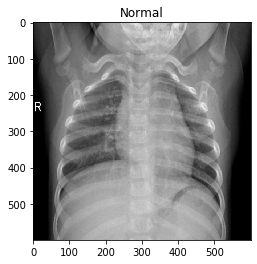

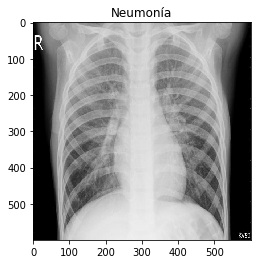

In [2]:
from tensorflow.keras.preprocessing.image import load_img

dataset_folderpath = "/tf/data/aa2020/data/v1"
print("Hay 3 directorios con los tres subconjuntos de datos: ",os.listdir(dataset_folderpath))
print("La carpeta de cada subconjunto tiene dos subcarpetas: normal y pneumonia")

train_folderpath = os.path.join(dataset_folderpath, "train")
val_folderpath = os.path.join(dataset_folderpath, "val")
test_folderpath = os.path.join(dataset_folderpath, "test")

img_name = '0000.jpg'
image_path= f'normal/{img_name}'
img_normal = load_img(os.path.join(train_folderpath, image_path))

print(f"Las imágenes tienen tamaño: {img_normal.size}")

plt.imshow(img_normal)
plt.title("Normal")
plt.show()

img_name = '0000.jpg'
image_path= f'pneumonia/{img_name}'
img_pneumonia = load_img(os.path.join(train_folderpath,image_path))
plt.imshow(img_pneumonia)
plt.title("Neumonía")
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# mismo preprocesamiento que el usado originalmente para entrenar MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Tamaño objetivo para escalar las imágenes. 
IMG_SIZE = 224
h,w,c = IMG_SIZE, IMG_SIZE, 3
batch_size = 32

# Preprocesamiento de cada subconjunto
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # mismo preprocesamiento que el usado originalmente para entrenar MobileNet
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # mismo preprocesamiento que el usado originalmente para entrenar MobileNet
    )

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # mismo preprocesamiento que el usado originalmente para entrenar MobileNet
    )

# Generadores de los subconjuntos. Reciben un directorio, y 
# cada carpeta del directorio se interpreta como una clase distinta.
# En este caso como cada directorio tiene 3 subdirectorios, normal, covid y pneumonia,
# por ende, habrá tres clases.
train_generator = train_datagen.flow_from_directory(
    train_folderpath, # directorio de donde cargar las imagenes (train)
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_folderpath, # directorio de donde cargar las imagenes (val)
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_folderpath, # directorio de donde cargar las imagenes (test)
    target_size=(h, w),
    batch_size=batch_size,
    class_mode=None, # IMPORTANTE ya que los ej de test no tienen clase
    shuffle=False # IMPORTANTE ya que nos importa el orden para el archivo de submission
    )


n_train = train_generator.samples
n_val = val_generator.samples
n_test = test_generator.samples
n_clases = train_generator.num_classes
print(f"Los conjuntos de train, val y test tienen {n_train}, {n_val} y {n_test} ejemplos respectivamente.")
print(f"Los conjuntos de datos tienen {n_clases} clases.")

Found 6915 images belonging to 2 classes.
Found 713 images belonging to 2 classes.
Found 1274 images belonging to 1 classes.
Los conjuntos de train, val y test tienen 6915, 713 y 1274 ejemplos respectivamente.
Los conjuntos de datos tienen 2 clases.


In [4]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.mobilenet import MobileNet

base_model = MobileNet(input_shape=(h, w, c), weights='imagenet', include_top=False) 

for layer in base_model.layers:
    layer.trainable = False # capas “congeladas” no se entrenan

output = GlobalAveragePooling2D()(base_model.output)    
# Utilizar salida del modelo como entrada a capa Dense de 128 
output = Dense(128, activation='relu')(output)
# Nueva capa de salida
output = Dense(1, activation='sigmoid')(output)

# Crear nuevo modelo en base a lo anterior
model = Model(inputs=base_model.input, outputs=output)

model.summary()

17227776/17225924 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________________________________

Total params: 3,360,193
Trainable params: 131,329
Non-trainable params: 3,228,864
_________________________________________________________________


In [5]:
from tensorflow.keras import backend as K
# Definición de las métricas F1, recall y precision utilizando Keras.

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.optimizers import Adam

lr = 1e-3
epochs = 5

optim = Adam(lr=lr, decay=lr / epochs)
val_steps = max(1, n_val // batch_size)

# Compilation with weighted metrics
model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy", f1_m, precision_m, recall_m])
model.fit_generator(train_generator,
                    steps_per_epoch=n_train // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_steps
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 216 steps, validate for 22 steps
Epoch 1/5
215/216 [============================>.] - ETA: 0s - loss: 0.1995 - accuracy: 0.9266 - f1_m: 0.9427 - precision_m: 0.9401 - recall_m: 0.9500

In [ ]:
# Evaluar el accuracy del modelo en el conjunto entero de entrenamiento
print("*********** Conjunto de entrenamiento ***********")
train_generator.reset()
_ = model.predict_generator(train_generator, steps=n_train // batch_size)
scores = model.evaluate_generator(train_generator, steps=n_train // batch_size)
for metric, score in zip(model.metrics_names, scores):
    print(f"{metric}: {score:.2f}")

print()
# Evaluar el accuracy del modelo en el conjunto entero de validación
print("*********** Conjunto de validación ***********")
val_generator.reset()
_ = model.predict_generator(val_generator, steps=n_val // batch_size)
scores = model.evaluate_generator(val_generator, steps=n_val // batch_size)
for metric, score in zip(model.metrics_names, scores):
    print(f"{metric}: {score:.2f}")

In [ ]:
import csv

# predecir sobre el conjunto de test y generar el csv resultante
y_prob = model.predict_generator(test_generator, steps=n_test // batch_size + 1)
# Establecer un umbral
treshold = 0.5
# Convertir probabilidades a etiquetas con el umbral
y_pred = (y_prob[:,0] > treshold).astype(int)
# quitar el nombre de la carpeta del nombre de archivo
filenames = [os.path.basename(f) for f in test_generator.filenames]
# igual cant de archivos que de predicciones
assert(len(y_pred) == len(filenames))

# Generar CSV con las predicciones
with open('solutions.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    writer.writerow(['Id', 'Predicted'])
    print("Id, Predicted")
    for f, y in zip(filenames, y_pred):
        print(f"{f}, {str(y)}")
        writer.writerow([f,str(y)])